# Предсказание стоимости жилья

В этом проекте мы обучим модель линейной регрессии на данных о жилье в Калифорнии в 1990 году используя средства pyspark. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Для оценки качества модели используем метрики RMSE, MAE и R2.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Дубликаты,-пропуски,-выбросы" data-toc-modified-id="Дубликаты,-пропуски,-выбросы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Дубликаты, пропуски, выбросы</a></span></li><li><span><a href="#Ohe" data-toc-modified-id="Ohe-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ohe</a></span></li><li><span><a href="#Scaler" data-toc-modified-id="Scaler-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Scaler</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression-на-всех-данных" data-toc-modified-id="LinearRegression-на-всех-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression на всех данных</a></span></li><li><span><a href="#LinearRegression-на-числовых-признаках" data-toc-modified-id="LinearRegression-на-числовых-признаках-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression на числовых признаках</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ результатов</a></span><ul class="toc-item"><li><span><a href="#LinearRegression-на-всех-данных" data-toc-modified-id="LinearRegression-на-всех-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression на всех данных</a></span></li><li><span><a href="#LinearRegression-на-числовых-признаках" data-toc-modified-id="LinearRegression-на-числовых-признаках-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LinearRegression на числовых признаках</a></span></li></ul></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></div>

## Обзор данных

Ипортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncoderEstimator as OneHotEncoder

Инициализируем локальную Spark-сессию и прочитаем содержимое файла /datasets/housing.csv:

In [2]:
spark = SparkSession \
        .builder \
        .master("local")\
        .appName("Median_house_value_prediction") \
        .getOrCreate() 

22/11/01 16:55:43 WARN Utils: Your hostname, iMac-Tana.local resolves to a loopback address: 127.0.0.1; using 192.168.0.107 instead (on interface en1)
22/11/01 16:55:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/01 16:55:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
df = spark.read.load('housing.csv', format="csv", sep=",", inferSchema=True, header="true")

Выведем типы данных колонок, первые 10 строк, общую статистику датасета и проверим пропущенные значения:

In [4]:
df.printSchema() 

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [5]:
df.limit(10).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [6]:
df.describe().toPandas().set_index('summary').T

summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0
ocean_proximity,20640,None,None,<1H OCEAN,NEAR OCEAN


In [7]:
display(pd.DataFrame(index=df.columns,
                     data=[df.filter(F.col(column).isNull()).count() for column in df.columns],
                     columns=['missing_values']))
print(f'Количество колонок: {len(df.columns)}',
      f'Количество записей: {df.count()}',
      sep='\n')

,missing_values
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


Количество колонок: 10
Количество записей: 20640


**Выводы:**

В датасете 20640 записей и 10 колонок. Типы данных в колонках `double` и `string`  соответстввуют содержащимся в них типам данных.

В каждой строке датасета содержится информация о жилом массиве Калифорнии 1990 года.

Согласно документации к данным, к признаками относятся следующие колонки:
* `longitude` — широта;
* `latitude` — долгота;
* `housing_median_age` — медианный возраст жителей жилого массива;
* `total_rooms` — общее количество комнат в домах жилого массива;
* `total_bedrooms` — общее количество спален в домах жилого массива;
* `population` — количество человек, которые проживают в жилом массиве;
* `households` — количество домовладений в жилом массиве;
* `median_income` — медианный доход жителей жилого массива;
* `ocean_proximity` — близость к океану.

Целевой признак:
* `median_house_value` — медианная стоимость дома в жилом массиве.

В данных присутствуют следующие аномалии:
- в колонке `total_bedrooms` 207 пропущенных значений (примерно 1% от всех данных);
- минимальные значения в колонках `housing_median_age`, `total_rooms`, `total_bedrooms`, `population` и `households` выглядят неправдоподобно;
- медианный доход жителей жилого массива в `median_income`, похоже, указан в тыс. долларов США, либо к данным было применено степенное преобразование.

## Подготовка данных

### Дубликаты, пропуски, выбросы

Проверим данные на дубликаты:

In [8]:
df.dropDuplicates().count()

20640

В возвращенном датасете столько же записей, сколько в оргинальном, значит дубликаты осутствуют.

Посмотрим на выбросы:

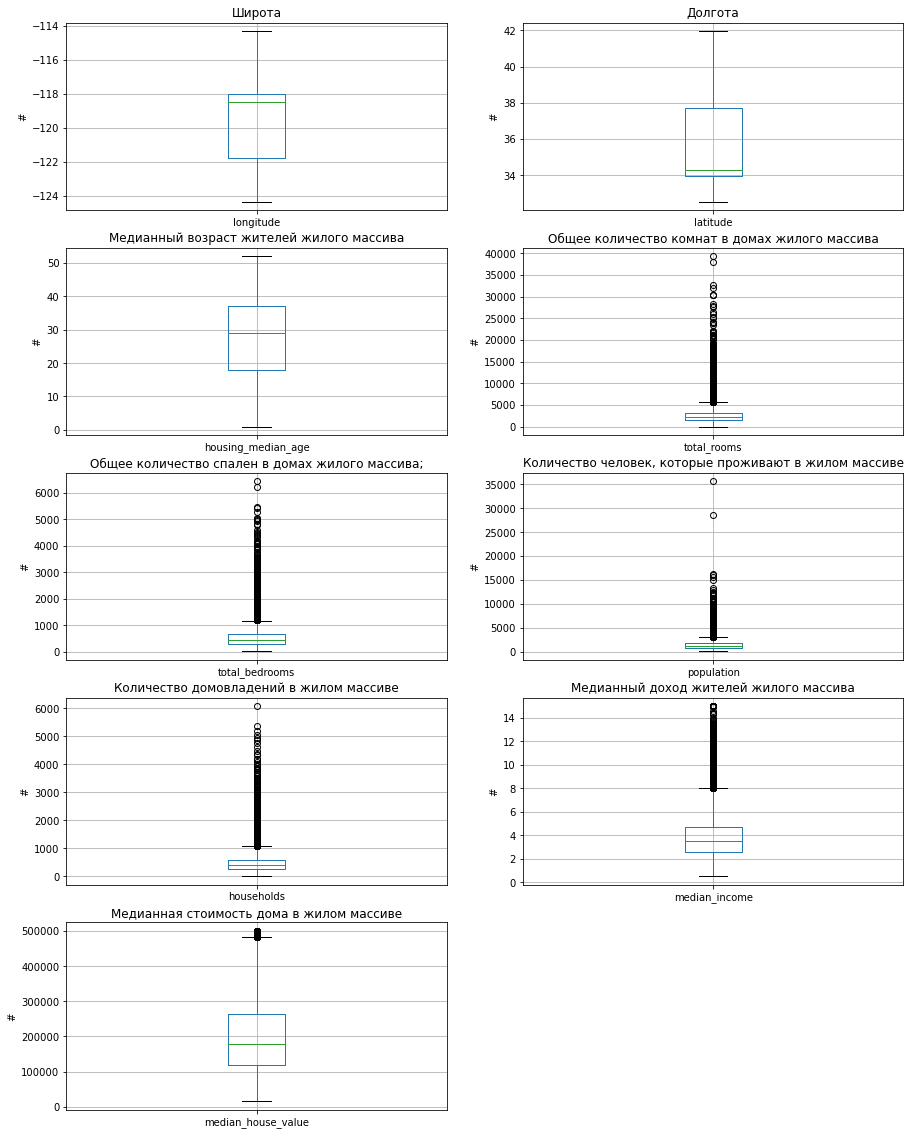

In [9]:
 column_list = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                    'population', 'households', 'median_income', 'median_house_value']

cnt = 1
plt.figure(figsize=(15, 20))
for column in column_list:
    plt.subplot(5, 2, cnt)
    df.select(F.col(column)).toPandas().boxplot()
    plt.ylabel('#')
    if cnt == 1:
        plt.title('Широта')
    if cnt == 2:
        plt.title('Долгота')
    if cnt == 3:
        plt.title('Медианный возраст жителей жилого массива')
    if cnt == 4:
        plt.title('Общее количество комнат в домах жилого массива')
    if cnt == 5:
        plt.title('Общее количество спален в домах жилого массива;')
    if cnt == 6:
        plt.title('Количество человек, которые проживают в жилом массиве')
    if cnt == 7:
        plt.title('Количество домовладений в жилом массиве')
    if cnt == 8:
        plt.title('Медианный доход жителей жилого массива')
    if cnt == 9:
        plt.title('Медианная стоимость дома в жилом массиве')
    cnt += 1

Во всех колонках, кроме `longitude`, `latitude` и `housing_median_age` есть выбросы. Удалим часть выбросов из обучающей выборки (после разделения датасета на тренировочную и тестовую выборки), при этом этом также ограничим медианный возраст 5 годами, а медианные стоимость дома и доход жителей жилого массива оставим без изменения.

Посмотрим на корреляцию между `total_bedrooms` и другими признаками:

In [10]:
total_bedrooms_correlation = []
for col in column_list:
    total_bedrooms_correlation.append(df.corr('total_bedrooms', col))

pd.DataFrame(index=column_list, data=total_bedrooms_correlation, columns=['corr']).sort_values('corr', ascending=False)

,corr
total_bedrooms,1.000000
households,0.966507
total_rooms,0.920196
population,0.866266
longitude,0.068082
median_house_value,0.049148
median_income,-0.007295
latitude,-0.065318
housing_median_age,-0.317063


Самая сильная корреляция `total_bedrooms` наблюдается с `households`, `total_rooms` и `population`. Рассчитаем отношение `total_bedrooms` и `households`, заполним пропуски в `total_bedrooms` с учетом этого соотношения:

In [11]:
df.withColumn('rate', F.col('total_bedrooms') / F.col('households')).select(F.col('rate')).describe().collect()[1]

Row(summary='mean', rate='1.0970623858069932')

In [12]:
df = df.withColumn('tmp', F.col('households') * 1.097) \
       .withColumn('total_bedrooms',
                   F.when(F.col('total_bedrooms').isNull(), F.col('tmp')).otherwise(F.col('total_bedrooms'))) \
       .drop('tmp')

df.filter(F.col('total_bedrooms').isNull()).count()

0

### Ohe

Трансформируем `ocean_proximity` с помощью `StringIndexer`:

In [13]:
indexer = StringIndexer(inputCols=['ocean_proximity'], 
                        outputCols=['ocean_proximity_idx']) 
df = indexer.fit(df).transform(df)
df.limit(5).toPandas() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


Трансформируем `ocean_proximity_idx` с помощью `OneHotEncoder`:

In [14]:
encoder = OneHotEncoder(inputCols=['ocean_proximity_idx'],
                        outputCols=['ocean_proximity_ohe'])
df = encoder.fit(df).transform(df)
df.limit(5).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"


Векторизуем `ocean_proximity_ohe`:

In [15]:
categorical_assembler = VectorAssembler(inputCols=['ocean_proximity_ohe'],
                                        outputCol='categorical_features')
df = categorical_assembler.transform(df)

### Scaler

Векторизуем числовые признаки:

In [16]:
numerical_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                  'population', 'households', 'median_income']
target = 'median_house_value'

In [17]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')
df = numerical_assembler.transform(df) 

Разделим датасет на обучающую и тестовую части:

In [18]:
train_data, test_data = df.randomSplit([.85,.15], seed=12345)
print(train_data.count(), test_data.count()) 

17460 3180


Удалим часть выбросов из тренировочной выборки:

In [19]:
train_data = train_data.filter((F.col('housing_median_age') > sum(df.approxQuantile('housing_median_age', [0.1], 0.2)))
                               & (F.col('total_rooms') < sum(df.approxQuantile('total_rooms', [0.95], 0.2)))
                               & (F.col('total_rooms') > sum(df.approxQuantile('total_rooms', [0.05], 0.2)))
                               & (F.col('total_bedrooms') < sum(df.approxQuantile('total_bedrooms', [0.95], 0.2)))
                               & (F.col('total_bedrooms') > sum(df.approxQuantile('total_bedrooms', [0.05], 0.2)))
                               & (F.col('population') < sum(df.approxQuantile('population', [0.95], 0.2)))
                               & (F.col('population') > sum(df.approxQuantile('population', [0.05], 0.2)))
                               & (F.col('households') < sum(df.approxQuantile('households', [0.95], 0.2)))
                               & (F.col('households') > sum(df.approxQuantile('households', [0.05], 0.2)))
                              )

In [20]:
print(train_data.count(), test_data.count()) 

17450 3180


Трансформируем тренировочную и тестовую выборки с помощью `StandardScaler`:

In [21]:
standardScaler = StandardScaler(inputCol='numerical_features',
                                outputCol='numerical_features_scaled')
scaler = standardScaler.fit(train_data)
train_data = scaler.transform(train_data) 
test_data = scaler.transform(test_data) 

Соберем трансформированные категорийные и числовые признаки с помощью `VectorAssembler`:

In [22]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
train_data = final_assembler.transform(train_data)
test_data = final_assembler.transform(test_data)

In [23]:
train_data.limit(10).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,categorical_features,numerical_features,numerical_features_scaled,features
0,-124.35,40.54,52.0,1820.0,300.0,806.0,270.0,3.0147,94600.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.35, 40.54, 52.0, 1820.0, 300.0, 806.0, 2...","[-62.00461326332602, 18.948781954776152, 4.132...","[0.0, 0.0, 1.0, 0.0, -62.00461326332602, 18.94..."
1,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.3, 41.8, 19.0, 2672.0, 552.0, 1298.0, 47...","[-61.979681774277644, 19.537717950410535, 1.51...","[0.0, 0.0, 1.0, 0.0, -61.979681774277644, 19.5..."
2,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.3, 41.84, 17.0, 2677.0, 531.0, 1244.0, 4...","[-61.979681774277644, 19.556414331224328, 1.35...","[0.0, 0.0, 1.0, 0.0, -61.979681774277644, 19.5..."
3,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.27, 40.69, 36.0, 2349.0, 528.0, 1194.0, ...","[-61.96472288084861, 19.018893382827866, 2.861...","[0.0, 0.0, 1.0, 0.0, -61.96472288084861, 19.01..."
4,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.26, 40.58, 52.0, 2217.0, 394.0, 907.0, 3...","[-61.95973658303894, 18.96747833558994, 4.1326...","[0.0, 0.0, 1.0, 0.0, -61.95973658303894, 18.96..."
5,-124.25,40.28,32.0,1430.0,419.0,434.0,187.0,1.9417,76100.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.25, 40.28, 32.0, 1430.0, 419.0, 434.0, 1...","[-61.95475028522926, 18.827255479486517, 2.543...","[0.0, 0.0, 1.0, 0.0, -61.95475028522926, 18.82..."
6,-124.23,40.81,52.0,1112.0,209.0,544.0,172.0,3.3462,50800.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.23, 40.81, 52.0, 1112.0, 209.0, 544.0, 1...","[-61.944777689609914, 19.074982525269235, 4.13...","[0.0, 0.0, 1.0, 0.0, -61.944777689609914, 19.0..."
7,-124.23,41.75,11.0,3159.0,616.0,1343.0,479.0,2.4805,73200.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.23, 41.75, 11.0, 3159.0, 616.0, 1343.0, ...","[-61.944777689609914, 19.5143474743933, 0.8742...","[0.0, 0.0, 1.0, 0.0, -61.944777689609914, 19.5..."
8,-124.22,41.73,28.0,3003.0,699.0,1530.0,653.0,1.7038,78300.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.22, 41.73, 28.0, 3003.0, 699.0, 1530.0, ...","[-61.939791391800235, 19.504999283986404, 2.22...","[0.0, 0.0, 1.0, 0.0, -61.939791391800235, 19.5..."
9,-124.21,40.75,32.0,1218.0,331.0,620.0,268.0,1.6528,58100.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","[-124.21, 40.75, 32.0, 1218.0, 331.0, 620.0, 2...","[-61.934805093990555, 19.04693795404855, 2.543...","[0.0, 0.0, 1.0, 0.0, -61.934805093990555, 19.0..."


## Обучение моделей

### LinearRegression на всех данных

Создадим и обучим модель линейной регрессии используя числовые и категорийные данные:

In [24]:
lr = LinearRegression(featuresCol='features', labelCol=target)

grid_search = ParamGridBuilder() \
              .addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
              .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
              .build()

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol=target,
                                metricName='rmse')

cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=12345)

cv_model = cv.fit(train_data)

best_model_all = cv_model.bestModel

print(f'Best regParam: {best_model_all._java_obj.getRegParam()}',
      f'Best elasticNetParam: {best_model_all._java_obj.getElasticNetParam()}',
      f'RMSE: {round(np.array(cv_model.avgMetrics).min())}',
      sep='\n')

22/11/01 16:56:16 WARN Instrumentation: [e0f07123] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:56:17 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/01 16:56:17 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/01 16:56:17 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/01 16:56:17 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/11/01 16:56:18 WARN Instrumentation: [8226b55f] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:56:19 WARN Instrumentation: [64e47632] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:56:20 WARN Instrumentation: [35fd97b4] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:56:20 WARN Instrumentation: [418f6cd7] regParam is zer

Best regParam: 1.0
Best elasticNetParam: 1.0
RMSE: 68315


Лучшая модель использует Elastic Net регуляризацию (гиперпараметры regParam=1 и elasticNetParam=1). RMSE лучшей модели составляет 68315 у.е.

### LinearRegression на числовых признаках

Создадим и обучим модель линейной регрессии используя только числовые данные:

In [25]:
lr = LinearRegression(featuresCol='numerical_features_scaled', labelCol=target)

grid_search = ParamGridBuilder() \
              .addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
              .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
              .build()

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol=target,
                                metricName='rmse')

cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=12345)

cv_model = cv.fit(train_data)

best_model_num = cv_model.bestModel

print(f'Best regParam: {best_model_num._java_obj.getRegParam()}',
      f'Best elasticNetParam: {best_model_num._java_obj.getElasticNetParam()}',
      f'RMSE: {round(np.array(cv_model.avgMetrics).min())}',
      sep='\n')

22/11/01 16:57:11 WARN Instrumentation: [f96c549a] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:57:12 WARN Instrumentation: [85ade0d6] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:57:12 WARN Instrumentation: [734b26c1] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:57:12 WARN Instrumentation: [761bbf1b] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:57:13 WARN Instrumentation: [5d86d68f] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:57:13 WARN Instrumentation: [629acdbc] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:57:18 WARN Instrumentation: [cb44e3bd] regParam is zero, which might cause numerical instability and overfitting.
22/11/01 16:57:19 WARN Instrumentation: [8810de93] regParam is zero, which might cause numerical instability and overf

Best regParam: 0.2
Best elasticNetParam: 0.2
RMSE: 69157


Лучшая модель использует Elastic Net регуляризацию (гиперпараметры regParam=0.2 и elasticNetParam=0.2). RMSE лучшей модели составляет 69157 у.е., что хуже, чем у модели, построенной на всех признаках.

## Анализ результатов

Сравним результаты работы моделей по метрикам RMSE, MAE и R2.

### LinearRegression на всех данных

In [26]:
predictions_all = best_model_all.transform(test_data)

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value')

print(f'MAE: {round(evaluator.evaluate(predictions_all, {evaluator.metricName: "mae"}))}',
      f'RMSE: {round(evaluator.evaluate(predictions_all, {evaluator.metricName: "rmse"}))}',
      f'R2: {round(evaluator.evaluate(predictions_all, {evaluator.metricName: "r2"}), 3)}',
      sep='\n')

MAE: 49381
RMSE: 68604
R2: 0.656


### LinearRegression на числовых признаках

In [27]:
predictions_num = best_model_num.transform(test_data)

print(f'MAE: {round(evaluator.evaluate(predictions_num, {evaluator.metricName: "mae"}))}',
      f'RMSE: {round(evaluator.evaluate(predictions_num, {evaluator.metricName: "rmse"}))}',
      f'R2: {round(evaluator.evaluate(predictions_num, {evaluator.metricName: "r2"}), 3)}',
      sep='\n')

MAE: 50465
RMSE: 69554
R2: 0.646


In [28]:
df.select(F.avg('median_house_value')).collect()

[Row(avg(median_house_value)=206855.81690891474)]

## Выводы:
При кросс валидации лучше себя показала модель, построенная на всех признаках, RMSE составляет 68315 у.е. У модели, построенной только на числовых признаках, RMSE составляет 69157 у.е.

На тестовой выборке:
* модель линейной регрессии, построенная на полном наборе данных с гиперпараметрами regParam=1 и elasticNetParam=1, в среднем ошибается на 49381 у.е. или на 23.9%, RMSE составляет 68604 у.е., R2 0.656 - 65,6% дисперсии целевой переменной объясняется моделью;
* модель, построенная только на числовых признаках с гиперпараметрами regParam=0.2 и elasticNetParam=0.2, показала себя немного хуже:
  - MAE: 50465 у.е. (в среднем ошибка на 24.4%)
  - RMSE: 69554 у.е.
  - R2: 0.646